In [14]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras import models, layers, optimizers, regularizers
# from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import cv2

import os

In an attempt to get a better split of train/test/validate, we've combined the original folders and resplit them up in the below field. The new ratio has 65% train, 15% validate, 20% test.

splitfolders.ratio("./data/combined/", output="combined_ttv", seed=42, ratio=(.65, .15, .2), group_prefix=None, move=True)

In [2]:
# Get photos for model training
# train = tf.keras.utils.image_dataset_from_directory('./data/archive/chest_xray/chest_xray/train')
# test = tf.keras.utils.image_dataset_from_directory('./data/archive/chest_xray/chest_xray/test')
# val = tf.keras.utils.image_dataset_from_directory('./data/archive/chest_xray/chest_xray/val')

In [3]:
def Get_Photo_Data(location, num_photos):
    '''
    Returns photos from data folder(resized, grayscaled) and binary class.
    
    '''
    datagen = ImageDataGenerator(rescale=1./255)
    
    data = datagen.flow_from_directory(
        location,
        target_size=(150, 150),
        batch_size=num_photos,
        color_mode='grayscale',
        class_mode='binary'
    )
    
    return data

In [4]:
#getting images and labels for models
train_photos = Get_Photo_Data('./combined_ttv/train/', 3805)
test_photos = Get_Photo_Data('./combined_ttv/test/', 1174)
val_photos = Get_Photo_Data('./combined_ttv/val/', 877)

Found 3805 images belonging to 2 classes.
Found 1174 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


In [5]:
# unpack images and labels for CM/dummy model
train_data, train_labels = next (train_photos)
test_data, test_labels = next (test_photos)
val_data, val_labels = next (val_photos)

# Model 7
For this model we made the following changes:
1. Combine and resplit train/test/validate to get more suitable numbers for each.


In [6]:
model = Sequential()

In [7]:
# Add layers to model
# input layer

model.add(Conv2D(64, (3,3), 1, activation='relu', padding = 'same', input_shape=(150,150,1)))

# add pooling layer(takes max from input window)
model.add(layers.MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), 1, activation='relu', padding = 'same'))

# add pooling layer(takes max from input window)
model.add(layers.MaxPooling2D((2,2)))

# flattens 2d to 1d
model.add(layers.Flatten())

# add dense layer
model.add(layers.Dense(16, activation='relu'))

model.add(Dropout(0.15))

# add output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# compile model with adam for binary model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy',
                                                                    Precision(name='precision'),
                                                                    Recall(name='recall')])

In [9]:
# fit model
history = model.fit(train_data,
               train_labels,
               batch_size=30,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
127/127 [==============================] - 12s 19ms/step - loss: 0.3857 - accuracy: 0.8223 - precision: 0.8152 - recall: 0.9784 - val_loss: 0.3138 - val_accuracy: 0.9179 - val_precision: 0.9356 - val_recall: 0.9531
Epoch 2/10
127/127 [==============================] - 2s 15ms/step - loss: 0.2766 - accuracy: 0.9141 - precision: 0.9181 - recall: 0.9687 - val_loss: 0.2422 - val_accuracy: 0.9407 - val_precision: 0.9482 - val_recall: 0.9719
Epoch 3/10
127/127 [==============================] - 2s 17ms/step - loss: 0.2440 - accuracy: 0.9438 - precision: 0.9517 - recall: 0.9723 - val_loss: 0.2309 - val_accuracy: 0.9384 - val_precision: 0.9347 - val_recall: 0.9844
Epoch 4/10
127/127 [==============================] - 2s 15ms/step - loss: 0.2308 - accuracy: 0.9401 - precision: 0.9512 - recall: 0.9676 - val_loss: 0.2196 - val_accuracy: 0.9430 - val_precision: 0.9443 - val_recall: 0.9797
Epoch 5/10
127/127 [==============================] - 2s 15ms/step - loss: 0.2141 - accuracy: 0.948

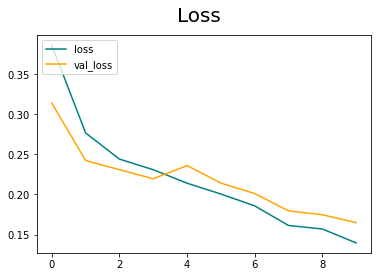

In [10]:
# examine loss of model across epochs
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

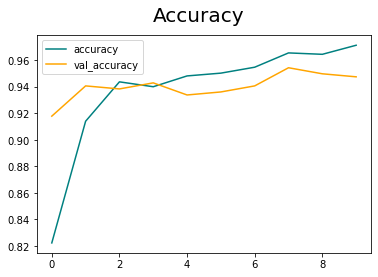

In [11]:
# examine accuracy of model across epochs
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
results=model.evaluate(test_data, test_labels)

37/37 [==============================] - 0s 7ms/step - loss: 0.1797 - accuracy: 0.9583 - precision: 0.9676 - recall: 0.9755


In [13]:
print(f"Model loss:  {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss:  0.17966260015964508
Model accuracy: 0.9582623243331909
Model precision: 0.967555046081543
Model recall: 0.9754672646522522


### Model 7 summary
Performance metrics for model 7 are much better than all previous models. By using a recombined dataset to get more balanced train/test/split, we're able to get much better scores with an identical model.

Compared to our dummy model, we have increased performance across all metrics(Recall is the same):
<br> ----------------Precision-----Accuracy-----Recall
<br> DUMMY--------0.63----------0.63-------------1
<br> FSM,3,4,5,6---0.71---------0.74---------0.98
<br> MODEL2------0.63----------0.63-------------1
<br> MODEL7------0.96----------0.95---------0.98

### Next steps
We can consider this our final model, as we are happy with these metrics. It turns out that the Mendeley set is identical to the kaggle set and so there is no need to apply this model to the other dataset.
<br>We will save this model for future use.

In [15]:
# model.save(os.path.join('model','pneumonia_classifier.h5'))